In [10]:
#data_dir = 'L:/DATA/ISIS/keras_ocr_training/'
data_dir = 'C:/model/'

import os
import math
import imgaug
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection
import tensorflow as tf
import datetime
import random
import string 
import tempfile
import cv2
from PIL import Image

import keras_ocr

tf.compat.v1.disable_eager_execution()
tf.compat.v1.experimental.output_all_intermediates(True)

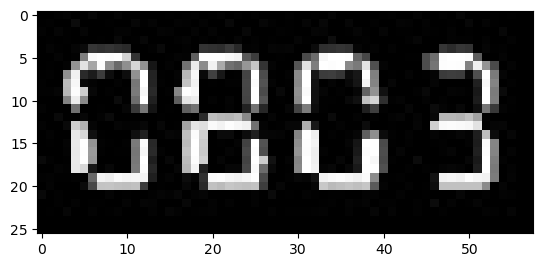

In [11]:
im = plt.imread(data_dir+'train_images/cropped_cleaned/n40_05.jpg')
plt.imshow(im)

In [12]:
import pandas as pd

# Import the annotations text files
dataset = pd.read_csv(data_dir+'train_images/cropped_cleaned/annotations.txt', header=None, 
                      names=['file','text'], dtype={'file' : str, 'text' : str})
# Create columns
dataset['file'] = data_dir+'train_images/cropped_cleaned/' + dataset['file']
dataset['text'] = dataset['text'].astype(str)
# The structure requires an empty column
dataset.insert(1, 'empty', None)
# Randomize the dataset
dataset = dataset.sample(frac=1)

dataset.tail(6)

,file,empty,text
633,C:/model/train_images/cropped_cleaned/q24_05.jpg,None,1159
668,C:/model/train_images/cropped_cleaned/q30_04.jpg,None,332
353,C:/model/train_images/cropped_cleaned/n23_01.jpg,None,41
336,C:/model/train_images/cropped_cleaned/n17_06.jpg,None,01
210,C:/model/train_images/cropped_cleaned/68.5.jpg,None,0314
223,C:/model/train_images/cropped_cleaned/74.6.jpg,None,41


In [13]:
train_subset, test_subset = sklearn.model_selection.train_test_split(dataset, test_size=0.2)

train_subset.reset_index(inplace=True, drop=True)
test_subset.reset_index(inplace=True, drop=True)

train = []
for i in range(len(train_subset)):
    train.append(tuple(train_subset.loc[i].to_list()))

test = []
for i in range(len(test_subset)):
    test.append(tuple(test_subset.loc[i].to_list()))

In [14]:
import string
recognizer = keras_ocr.recognition.Recognizer(alphabet=string.digits)
#recognizer.model.load_weights('L:/DATA/ISIS/keras_ocr_training/ISIS_reading.h5')
#recognizer.model.load_weights('C:/model/recognizer_2024-01-25T15.h5')
recognizer.compile()




Provided alphabet does not match pretrained alphabet. Using backbone weights only.
Looking for C:\Users\jpasillasdiaz\.keras-ocr\crnn_kurapan_notop.h5
Provided alphabet does not match pretrained alphabet. Using backbone weights only.
Looking for C:\Users\jpasillasdiaz\.keras-ocr\crnn_kurapan_notop.h5


In [15]:
batch_size = 20
# augmenter = imgaug.augmenters.Sequential([
#     imgaug.augmenters.GammaContrast(gamma=(0.25, 3.0)),
#     # imgaug.augmenters.GaussianBlur(sigma=(0, 3.0)),
#     # imgaug.augmenters.LinearContrast((0.75, 1.5)),
#     # imgaug.augmenters.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
#     #imgaug.augmenters.Multiply((0.8, 1.2), per_channel=0.2),
#     # imgaug.augmenters.Affine(
#     #     scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
#     #     translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
#     #     rotate=(-25, 25),
#     #     shear=(-8, 8))
# ],random_order=True)


augmenter = imgaug.augmenters.Sequential([
    imgaug.augmenters.GaussianBlur((1,1), 0)
],random_order=True)

(training_image_gen, training_steps), (validation_image_gen, validation_steps) = [
    (
        keras_ocr.datasets.get_recognizer_image_generator(
            labels=labels,
            height=recognizer.model.input_shape[1],
            width=recognizer.model.input_shape[2],
            alphabet=recognizer.alphabet,
            augmenter=augmenter
        ),
        len(labels) // batch_size
    ) for labels, augmenter in [(train, augmenter), (test, None)]
]
training_gen, validation_gen = [
    recognizer.get_batch_generator(
        image_generator=image_generator,
        batch_size=batch_size
    )
    for image_generator in [training_image_gen, validation_image_gen]
]

text: 41


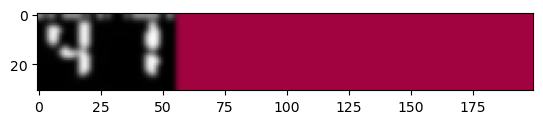

In [16]:
# Example
image, text = next(training_image_gen)
print('text:', text)
plt.imshow(image)

In [19]:
recognizer_basepath = os.path.join('C:/model/', f'recognizer_{datetime.datetime.now().isoformat()[0:13]}')

callbacks=[
    tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=3),
    tf.keras.callbacks.CSVLogger(f'{recognizer_basepath}.csv', append=True),
    tf.keras.callbacks.ModelCheckpoint(filepath=f'{recognizer_basepath}.h5')        
    ]
history = recognizer.training_model.fit(
    training_gen,
    # steps_per_epoch=training_steps,
    steps_per_epoch=80,#20
    validation_steps=21,#validation_steps
    validation_data=validation_gen,
    callbacks=callbacks,
    epochs=30,
    workers=1
)


Epoch 1/30

80/80 [==============================] - ETA: 0s - batch: 39.5000 - size: 20.0000 - loss: 4.7283

C:\Users\jpasillasdiaz\.conda\envs\image_recognition\Lib\site-packages\keras\src\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
C:\Users\jpasillasdiaz\.conda\envs\image_recognition\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


80/80 [==============================] - 424s 5s/step - batch: 39.5000 - size: 20.0000 - loss: 4.7283 - val_loss: 0.4071
Epoch 2/30
80/80 [==============================] - 406s 5s/step - batch: 39.5000 - size: 20.0000 - loss: 0.1458 - val_loss: 0.1244
Epoch 3/30
80/80 [==============================] - 409s 5s/step - batch: 39.5000 - size: 20.0000 - loss: 0.0408 - val_loss: 0.0409
Epoch 4/30
80/80 [==============================] - 403s 5s/step - batch: 39.5000 - size: 20.0000 - loss: 0.0019 - val_loss: 0.0210
Epoch 5/30
80/80 [==============================] - 403s 5s/step - batch: 39.5000 - size: 20.0000 - loss: 0.0277 - val_loss: 0.1759
Epoch 6/30
80/80 [==============================] - 407s 5s/step - batch: 39.5000 - size: 20.0000 - loss: 0.0839 - val_loss: 0.1097
Epoch 7/30
80/80 [==============================] - 408s 5s/step - batch: 39.5000 - size: 20.0000 - loss: 2.9096e-04 - val_loss: 1.5603e-04
Epoch 8/30
80/80 [==============================] - 405s 5s/step - batch: 39.50

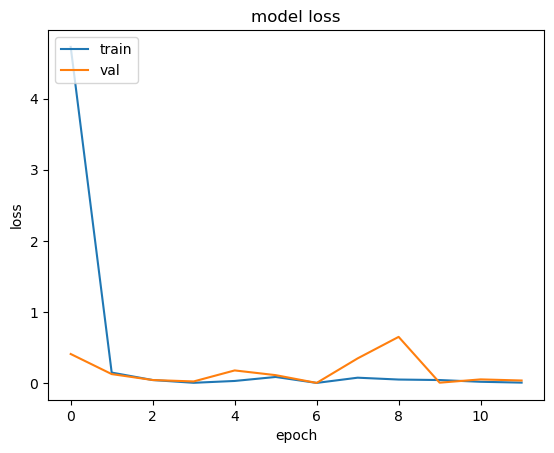

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

('C:/model/train_images/cropped_cleaned/n6_03.jpg', None, '69')


C:\Users\jpasillasdiaz\.conda\envs\image_recognition\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Predicted: 69, Actual: 69


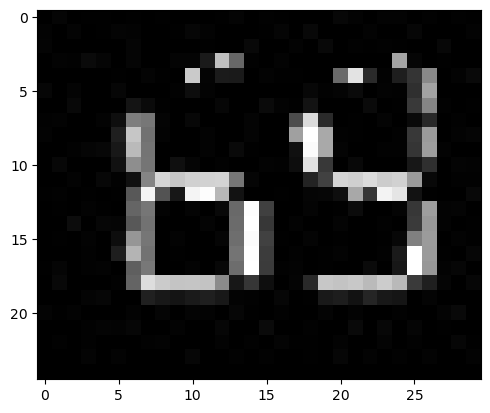

In [21]:
single_image_test=1
image_filepath, _, actual = test[single_image_test]
print (test[single_image_test])
predicted = recognizer.recognize(image_filepath)
print(f'Predicted: {predicted}, Actual: {actual}')
_ = plt.imshow(keras_ocr.tools.read(image_filepath))

# Trainng accuracy

In [22]:
all_labeled_images = list(dataset.itertuples(index=False))
correct_predictions = 0
incorrect_predictions = 0
for image_filepath, _, actual in all_labeled_images:
    predicted = recognizer.recognize(image_filepath)
    if predicted == actual:
        correct_predictions+=1
    else:
        incorrect_predictions+= 1
        print(f'Predicted: {predicted}, Actual: {actual}, File_path: {image_filepath}')
        plt.subplots(1, 1, figsize=(1,1))
        _ = plt.imshow(keras_ocr.tools.read(image_filepath))
        plt.show()
    
            
print(f'Total images evelauted: {correct_predictions+incorrect_predictions}')
accuracy = correct_predictions / dataset.shape[0]
print(f'Train and test Accuracy:  {accuracy}')

Total images evelauted: 677
Train and test Accuracy:  1.0


In [23]:
pipeline = keras_ocr.pipeline.Pipeline(recognizer=recognizer)
pipeline_original = keras_ocr.pipeline.Pipeline(recognizer=recognizer_original)

Looking for C:\Users\jpasillasdiaz\.keras-ocr\craft_mlt_25k.h5
Instructions for updating:
Use `tf.image.resize(...method=ResizeMethod.BILINEAR...)` instead.
Looking for C:\Users\jpasillasdiaz\.keras-ocr\craft_mlt_25k.h5


In [24]:
imageHeight = 50
top_noise_height = 10
bottom_noise_height = 10
threshold_toLine=(110, 110, 110, 255)
threshold_towhite=(0, 0, 0, 255)
threshold_toblack=(80, 80, 80, 255)
start_row_to_process = 1
end_row_to_process = 20

In [25]:
#Staring by defining a crop and copy function: 
def crop_and_copy(input_path, output_path, imageHeight):
    # Open the input image
    with Image.open(input_path) as img:
        # Get the dimensions of the image
        width, height = img.size
        # Define the region to crop (imageHeight pixels from the bottom)
        crop_region = (0, height - imageHeight, width, height)
        # Crop the image
        cropped_img = img.crop(crop_region)
        # Create a new image with the same size as the cropped region
        new_img = Image.new("RGBA", (width, imageHeight), (0, 0, 0, 0))
        # Paste the cropped region onto the new image
        new_img.paste(cropped_img, (0, 0))
        # Save the result to the output path
        new_img.save(output_path.name)

# Continue then with a function to remove top noise and overwrite the image
def remove_top_bottom_noise(input_path, top_noise_height, bottom_noise_height):
    # Open the image
    with Image.open(input_path) as img:
        # Get the dimensions of the image
        width, height = img.size
        # Create a new image with the same content as the original
        new_img = img.copy()

        # Add a black border to the top noise height
        for y in range(top_noise_height):
            for x in range(width):
                new_img.putpixel((x, y), (0, 0, 0, 255))  # Set pixel to black
        # Remove noise from the bottom
        for y in range(height - bottom_noise_height, height):
            for x in range(width):
                new_img.putpixel((x, y), (0, 0, 0, 255))  # Set pixel to black

        # Save the result, overwriting the original image
        new_img.save(input_path.name)

def process_middle_lines_noise(input_path, threshold_toline, start_row, end_row):
    # Open the image
    img = Image.open(input_path)
    
    # Get the pixels
    pixels = img.load()
    width, height = img.size
    # Iterate through rows to process and replace colors below the threshold
    for y in range(start_row, end_row + 1):
        for x in range(width):
            r, g, b, a = pixels[x, y]
            if (r, g, b, a) < threshold_toline:
                pixels[x, y] = (0, 0, 0, 255)
    # Iterate through all rows to process the below threshold rest pixels to black
    for y in range(top_noise_height, imageHeight-bottom_noise_height):
        if y == 19 or y == 20:
           continue
        for x in range(width):
            r, g, b, a = pixels[x, y]
            if (r, g, b, a) < threshold_toblack:
                pixels[x, y] = (0, 0, 0, 255)
    # Iterate through all rows to process the rest pixels to white
    for y in range(top_noise_height, imageHeight-bottom_noise_height):
        for x in range(width):
            r, g, b, a = pixels[x, y]
            if (r, g, b, a) > threshold_towhite:
                pixels[x, y] = (255, 255, 255, 255)
    # Save the modified image
    img.save(input_path.name)
    return img

In [26]:
def drawBoxes(image, boxes, color=(0, 0, 255), thickness=4, boxes_format="boxes"):
    """Draw boxes onto an image.

    Args:
        image: The image on which to draw the boxes.
        boxes: The boxes to draw.
        color: The color for each box.
        thickness: The thickness for each box.
        boxes_format: The format used for providing the boxes. Options are
            "boxes" which indicates an array with shape(N, 4, 2) where N is the
            number of boxes and each box is a list of four points) as provided
            by `keras_ocr.detection.Detector.detect`, "lines" (a list of
            lines where each line itself is a list of (box, character) tuples) as
            provided by `keras_ocr.data_generation.get_image_generator`,
            or "predictions" where boxes is by itself a list of (word, box) tuples
            as provided by `keras_ocr.pipeline.Pipeline.recognize` or
            `keras_ocr.recognition.Recognizer.recognize_from_boxes`.
    """
    if len(boxes) == 0:
        return image
    canvas = image.copy()
    if boxes_format == "lines":
        revised_boxes = []
        for line in boxes:
            for box, _ in line:
                revised_boxes.append(box)
        boxes = revised_boxes
    if boxes_format == "predictions":
        revised_boxes = []
        for _, box in boxes:
            revised_boxes.append(box)
        boxes = revised_boxes
    for box in boxes:
        cv2.polylines(
            img=canvas,
            pts=box[np.newaxis].astype("int32"),
            color=color,
            thickness=thickness,
            isClosed=True,
        )
    return canvas

keras_ocr.tools.drawBoxes = drawBoxes

In [27]:
def read_image(image_path, pipeline,just_digits=False):
    try: 
        #applying cropping and de-noising filters
        output_file_path = tempfile.NamedTemporaryFile(delete = False, suffix=".png")
        crop_and_copy(image_path, output_file_path, imageHeight)
        remove_top_bottom_noise(output_file_path,top_noise_height,bottom_noise_height)
        image = process_middle_lines_noise(output_file_path,threshold_toLine,start_row_to_process,end_row_to_process)

        #saving image to temporary path
        temp_file_path = tempfile.NamedTemporaryFile(delete=False, suffix=".png")
        # plt.axis("off")        
        # plt.imshow(image)
        # plt.savefig(temp_file_path.name)
        # plt.close()

        #reading both filtered & orignal image 
        image = keras_ocr.tools.read(output_file_path.name) 
        image_original = keras_ocr.tools.read(image_path) 

        list_images = []
        digitcount_total = []
        predicted_values =[]
        list_images.append(image)
        #list_images.append(image_original)
        
        # plt.axis("off")        
        # plt.imshow(image_original)
        # plt.show()
        # plt.close()

        # plt.axis("off")        
        # plt.imshow(image)
        # plt.show()
        # plt.close()

        #applying KERAS on each image to compare performance
      
        for im in list_images:
            predicted_values=[]
            prediction = pipeline.recognize([im])[0]
            # if no characters are found move on
            if prediction == [[]]:
                digit_count = 0

            # if characters are found look at the predictions
            else:
                
                #plt.figure(figsize=(40, 20))
                fig, ax = plt.subplots(1, 1, figsize=(20,7))
                keras_ocr.tools.drawAnnotations(image=image, predictions=prediction,ax=ax)
                plt.show()
                plt.close()
                # loop over predicted (word, box) tuples and count number of digit characters
                digit_count, max_x, min_x, box_count = 0, -np.inf, np.inf, 0 # CHANGE
                candidate_char_boxes = []
                for p in prediction:

                    # select word and box part of the tuple
                    value, box = p[0], p[1]
                    #box = box[0][0][1][: ,1]+200
                
                    # if word is composed of just integers then 
                    # count how many and increment digit_count
                    if just_digits == False or (just_digits == True and value.isdigit()): # loop over each digit?
                        # check that box is within the cropped height
                        in_bounds = True
                        
                        if in_bounds: 
                            box_count +=1 
                            digit_count += len(value)

                            # save difference between lowest and highest x value
                            # (for max_d)
                            if box[0,0] > max_x: # top left corner ?
                                max_x = box[0,0]
                            if box[0,1] < min_x: # top right corner ?
                                min_x = box[0,1]
                                
                            # save all char positions (for max_d_no_char use later)
                            candidate_char_boxes.append(box)                     
            
            # sort the boxes from left to right by top left value
            candidate_char_boxes.sort(key=lambda candidate_char_boxes: candidate_char_boxes[0,0])
            digitcount_total.append(digit_count)
            #print([item[0] for item in prediction])
            predicted_values.append([item[0] for item in prediction])
        print(predicted_values)

    except Exception as e:
        print('ERR:', e)

    print('Filtered Image digits count:', digitcount_total[0])# 'Original Image digit count:', digitcount_total[1])
    #print([item[0] for item in prediction])
    output_file_path.close()
    os.unlink(output_file_path.name)

    return digitcount_total, len(candidate_char_boxes),predicted_values

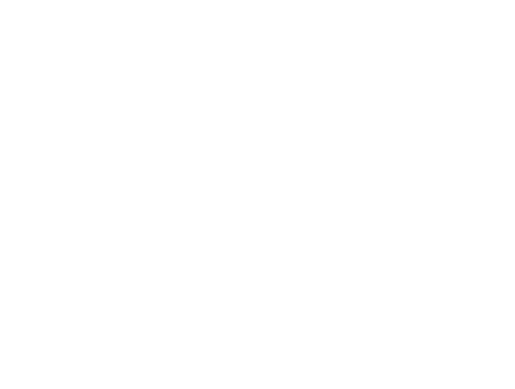

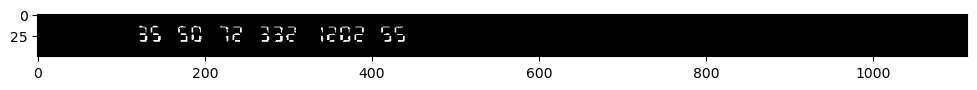

In [29]:
image_path = "C:/model/train_images/ISIS_102000056114R014207899B1-35-9 ISIS A C-1672/Image0031.png"
#image_path = "C:/model/train_images/original/55.png"

# plt.figure(figsize=(20, 14))
# #plt.figure(1)

# plt.subplot(211)
# im_unmodified = plt.imread(image_path)
# plt.imshow(im_unmodified)

output_file_path = tempfile.NamedTemporaryFile(delete = False, suffix=".png")
crop_and_copy(image_path, output_file_path, imageHeight)
remove_top_bottom_noise(output_file_path,top_noise_height,bottom_noise_height)
image = process_middle_lines_noise(output_file_path,threshold_toLine,start_row_to_process,end_row_to_process)

#saving image to temporary path
temp_file_path = tempfile.NamedTemporaryFile(delete=False, suffix=".png")
plt.axis("off")        
plt.imshow(image)
plt.savefig(temp_file_path.name)
plt.close()

#reading both filtered & orignal image 
image = keras_ocr.tools.read(output_file_path.name) 

crop_and_copy(image_path, output_file_path, imageHeight)
remove_top_bottom_noise(output_file_path,top_noise_height,bottom_noise_height)
image_original = keras_ocr.tools.read(output_file_path.name) 
#image_original = keras_ocr.tools.read(image_path) 

list_images = []
digitcount_total = []
list_images.append(image)
list_images.append(image_original)
        
# plt.axis("off")     
# plt.figure(figsize=(12, 10))
# plt.imshow(image_original)
# plt.show()
# plt.close()

plt.axis("off")  
plt.figure(figsize=(12, 10))
plt.imshow(image)
plt.show()
plt.close()

# KNN

In [30]:
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.model_selection import train_test_split
# knn_clf = KNeighborsClassifier()
# knn_clf.fit(training_gen) 

In [31]:
# training_gen, validation_gen = [
#     recognizer.get_batch_generator(
#         image_generator=image_generator,
#         batch_size=batch_size
#     )
#     for image_generator in [training_image_gen, validation_image_gen]
# ]

In [32]:
# X_train, y_train = next(validation_gen)

In [42]:
sample_size = 50

#sub_directory = "L:/DATA/ISIS/ISIS_101300030772/b7_R014207896/B1-34-50 ISIS A C-260"
sub_directory = "C:/model/train_images/original"
random.seed(4500)
image_list = []
for root, dirs, files in os.walk(sub_directory):
    for file in files:
        if 'csv' not in file:
            image_list.append(os.path.join(root,file))  
sample_set = np.random.choice(image_list, sample_size, False)

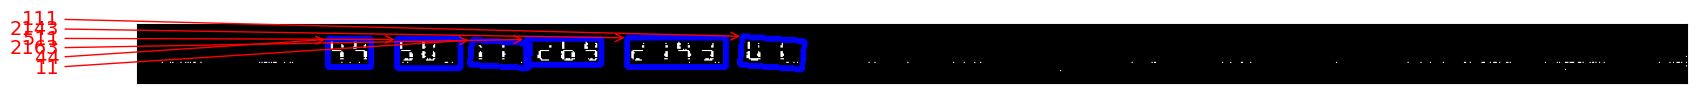

[['511', '2163', '2143', '111', '44', '11']]
Filtered Image digits count: 18


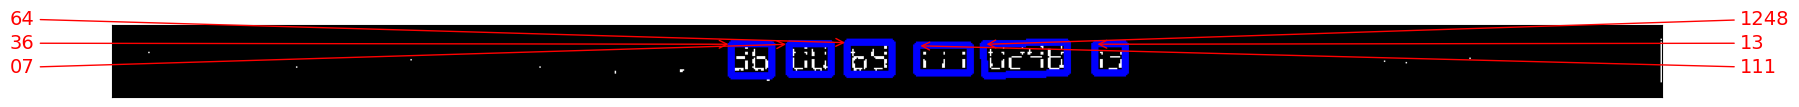

[['64', '1248', '36', '07', '13', '111']]
Filtered Image digits count: 15


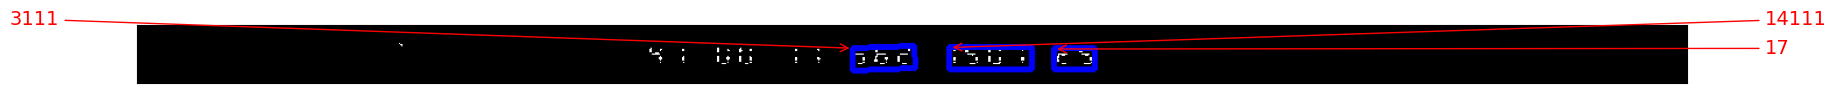

[['3111', '14111', '17']]
Filtered Image digits count: 11


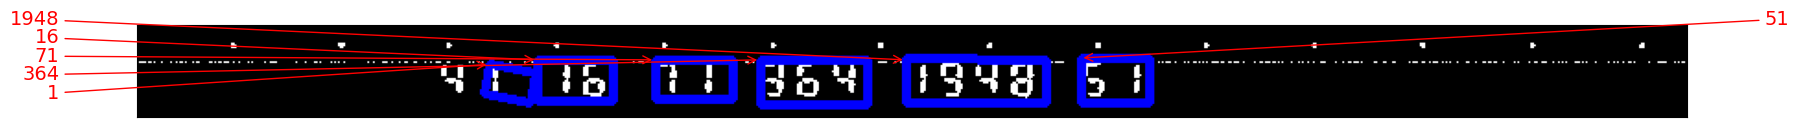

[['51', '16', '71', '364', '1948', '1']]
Filtered Image digits count: 14


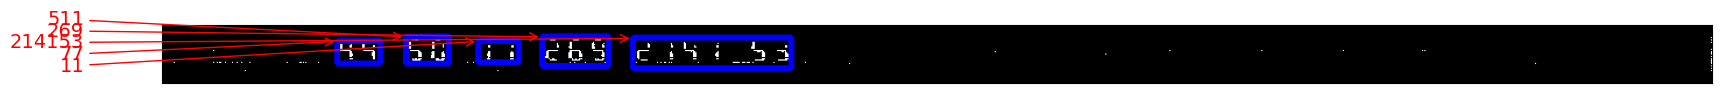

[['511', '269', '214153', '77', '11']]
Filtered Image digits count: 16


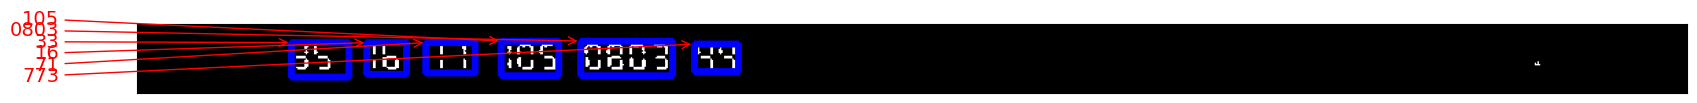

[['105', '0803', '33', '16', '71', '773']]
Filtered Image digits count: 16


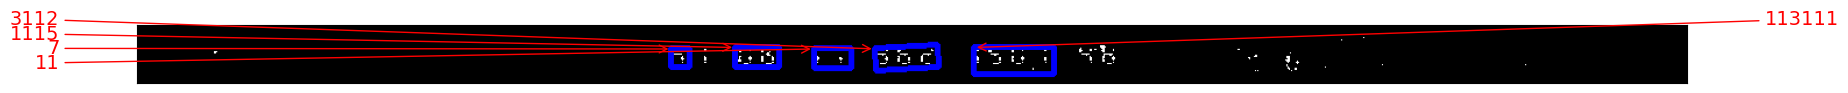

[['1115', '3112', '113111', '7', '11']]
Filtered Image digits count: 17


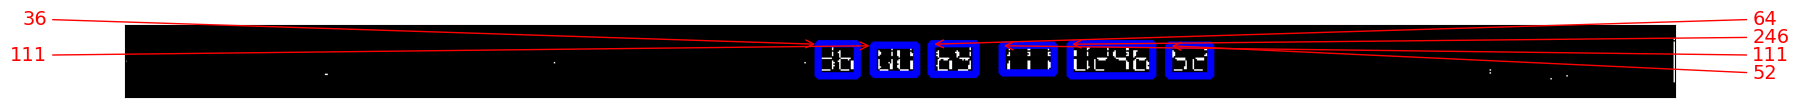

[['36', '64', '246', '111', '111', '52']]
Filtered Image digits count: 15


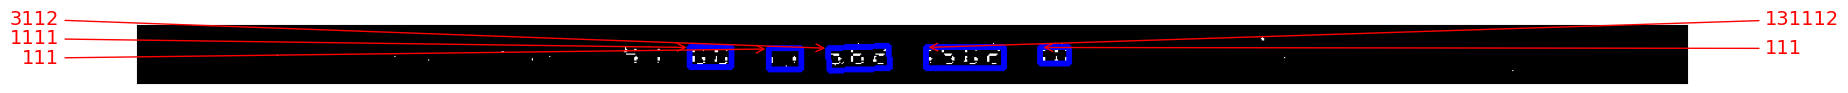

[['1111', '3112', '131112', '111', '111']]
Filtered Image digits count: 20


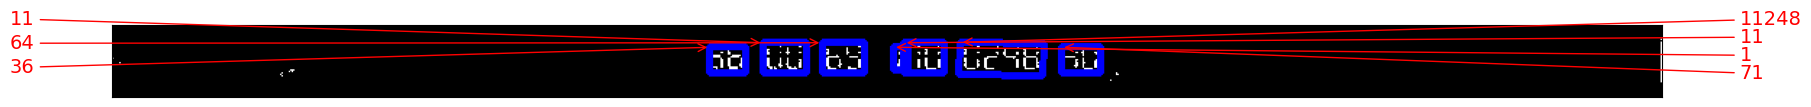

[['11', '64', '11', '11248', '36', '1', '71']]
Filtered Image digits count: 16


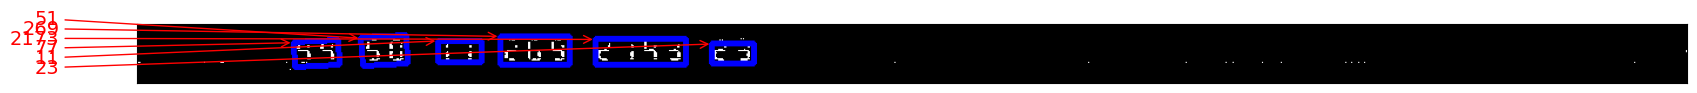

[['51', '269', '2173', '77', '11', '23']]
Filtered Image digits count: 15


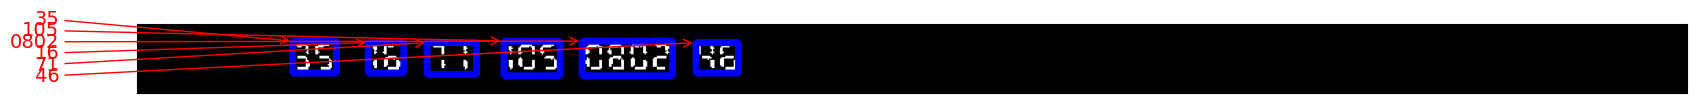

[['35', '105', '0802', '16', '71', '46']]
Filtered Image digits count: 15


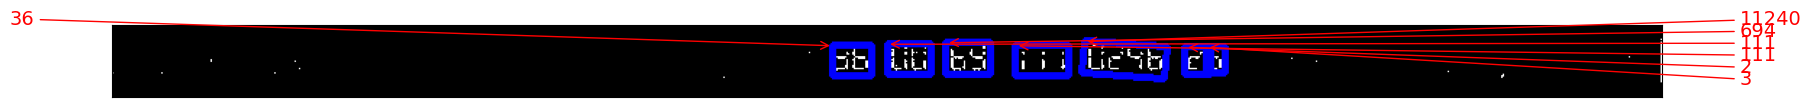

[['694', '11240', '111', '36', '111', '2', '3']]
Filtered Image digits count: 18


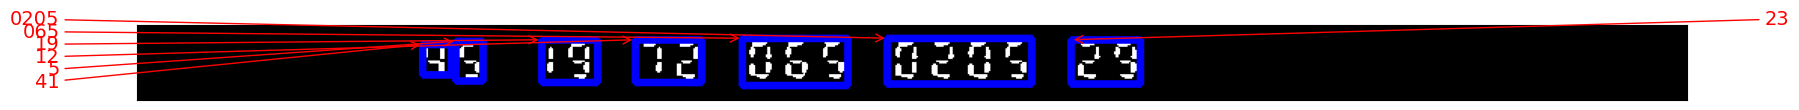

[['19', '065', '0205', '5', '12', '23', '41']]
Filtered Image digits count: 16


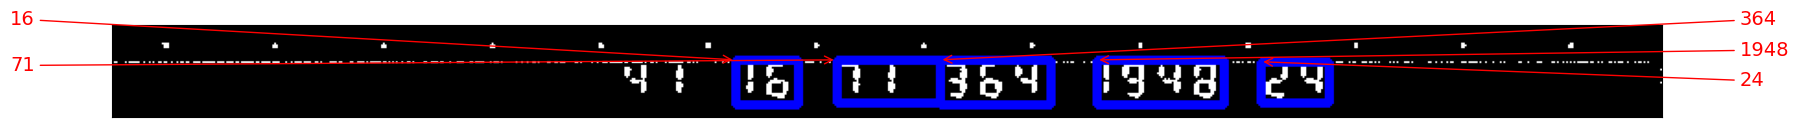

[['16', '71', '364', '1948', '24']]
Filtered Image digits count: 13


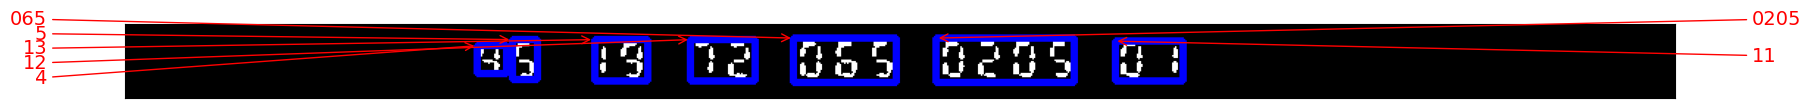

[['5', '13', '12', '065', '0205', '11', '4']]
Filtered Image digits count: 15


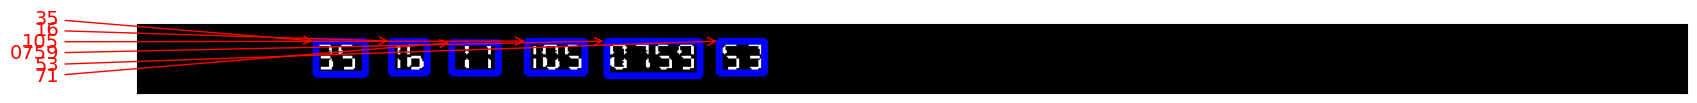

[['35', '16', '105', '0759', '53', '71']]
Filtered Image digits count: 15


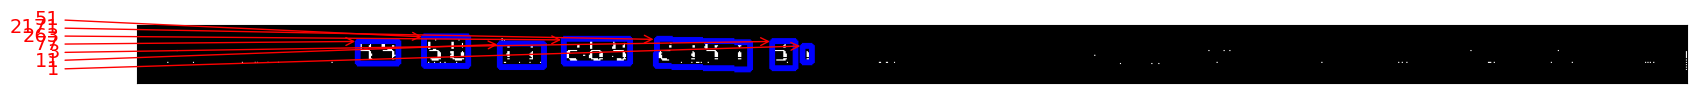

[['51', '263', '2171', '77', '3', '11', '1']]
Filtered Image digits count: 15


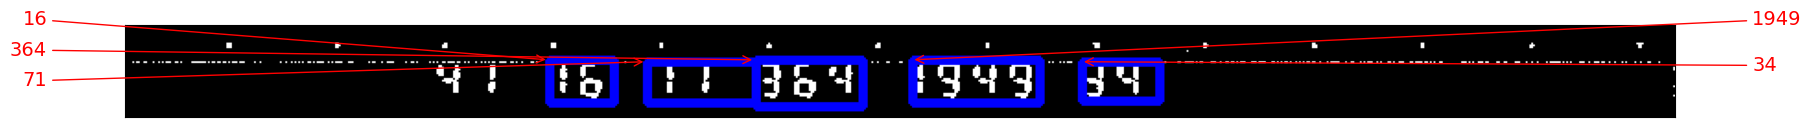

[['16', '364', '1949', '71', '34']]
Filtered Image digits count: 13


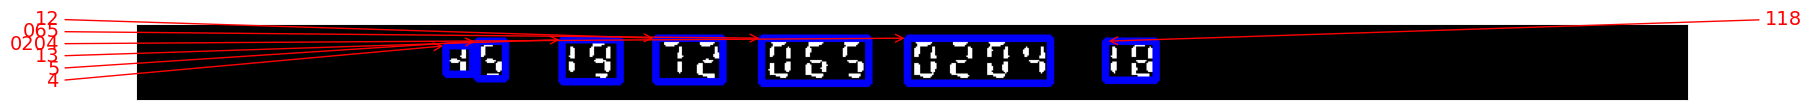

[['13', '12', '065', '0204', '5', '118', '4']]
Filtered Image digits count: 16


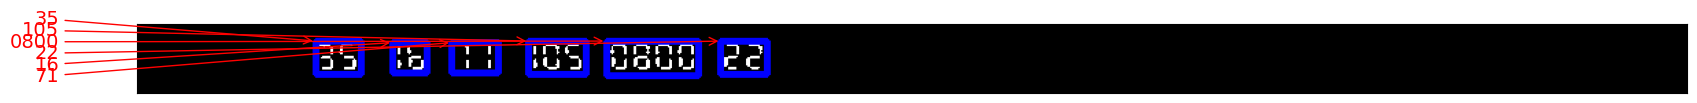

[['35', '105', '0800', '22', '16', '71']]
Filtered Image digits count: 15


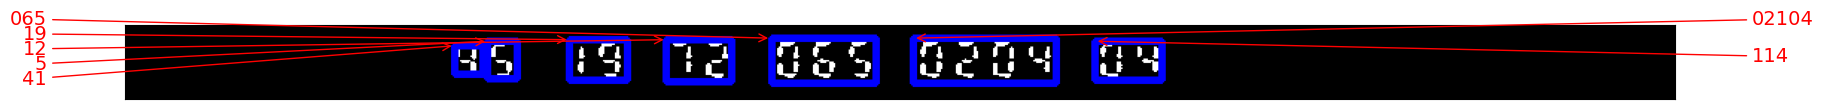

[['19', '12', '065', '02104', '5', '114', '41']]
Filtered Image digits count: 18


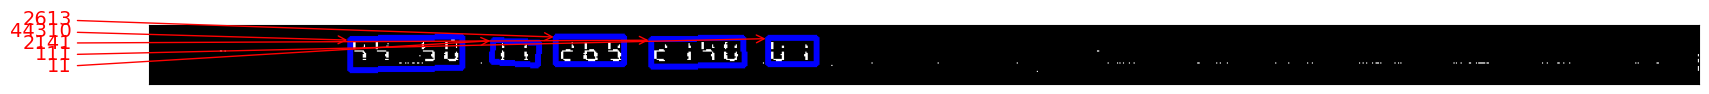

[['2613', '2141', '111', '44310', '11']]
Filtered Image digits count: 18


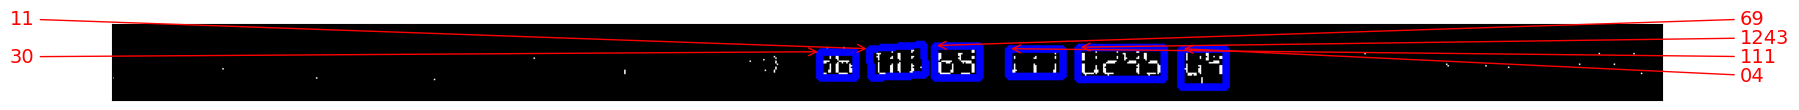

[['69', '11', '1243', '111', '04', '30']]
Filtered Image digits count: 15


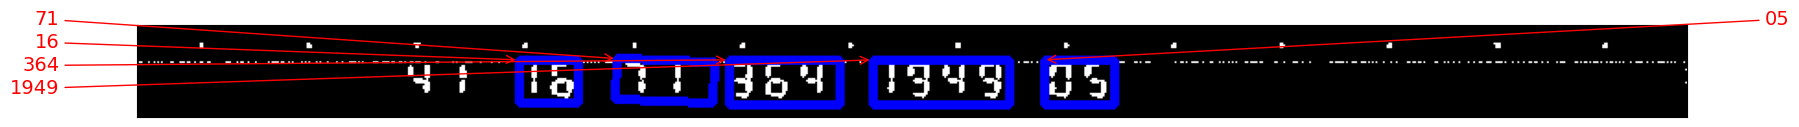

[['16', '71', '364', '1949', '05']]
Filtered Image digits count: 13


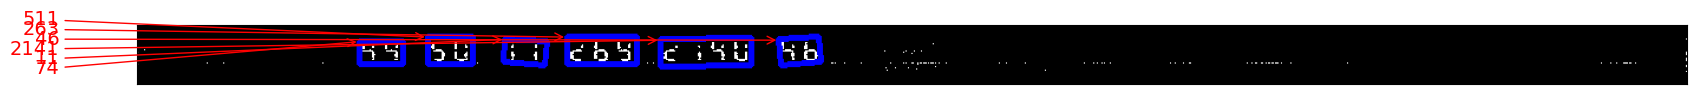

[['511', '263', '2141', '46', '11', '74']]
Filtered Image digits count: 16


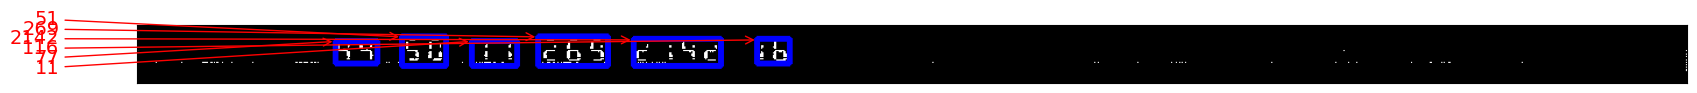

[['51', '269', '2142', '116', '77', '11']]
Filtered Image digits count: 16


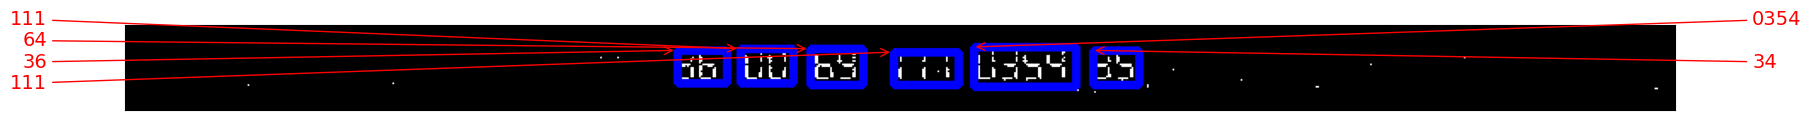

[['0354', '111', '64', '36', '34', '111']]
Filtered Image digits count: 16


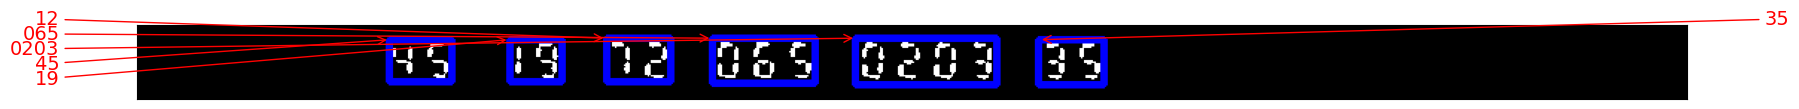

[['45', '19', '12', '065', '0203', '35']]
Filtered Image digits count: 15


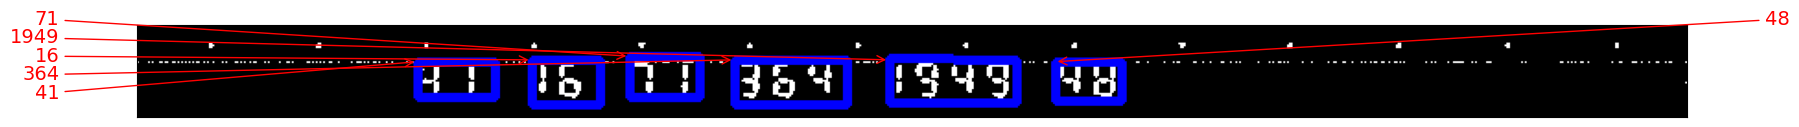

[['71', '16', '364', '1949', '41', '48']]
Filtered Image digits count: 15


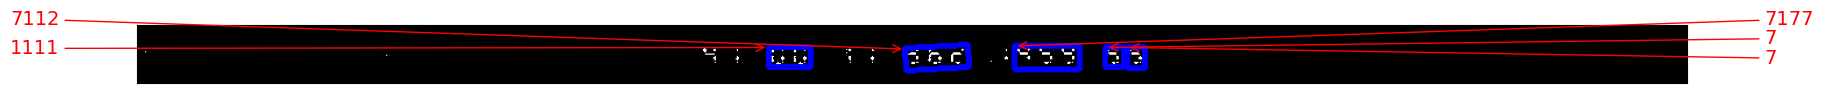

[['7177', '1111', '7112', '7', '7']]
Filtered Image digits count: 14


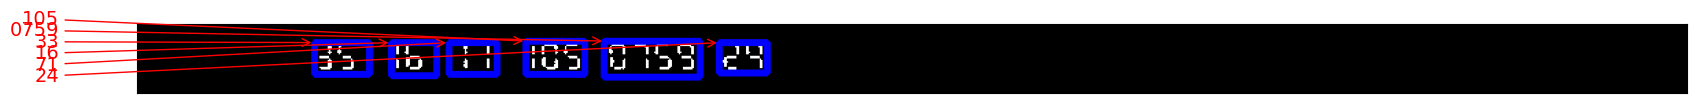

[['105', '0759', '33', '16', '71', '24']]
Filtered Image digits count: 15


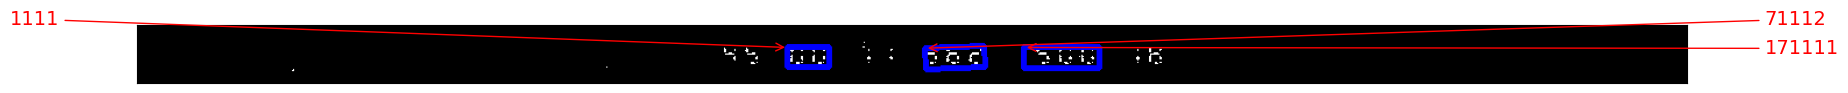

[['1111', '71112', '171111']]
Filtered Image digits count: 15


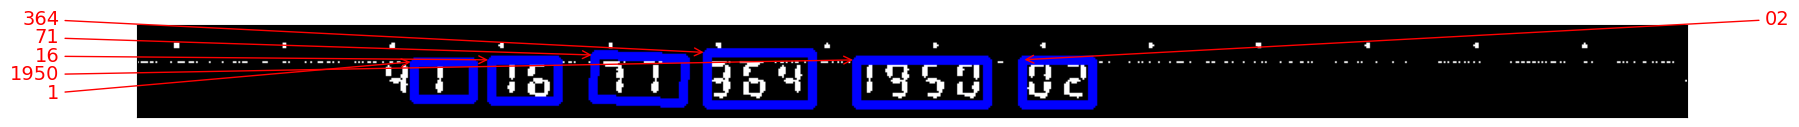

[['364', '71', '16', '1950', '02', '1']]
Filtered Image digits count: 14


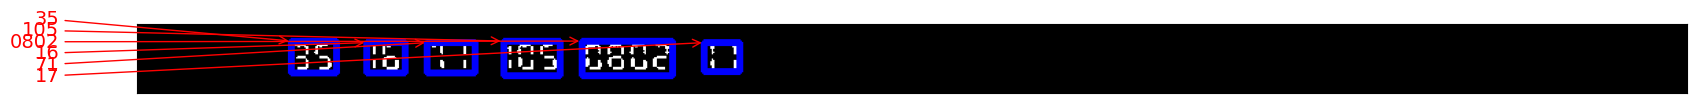

[['35', '105', '0802', '16', '71', '17']]
Filtered Image digits count: 15


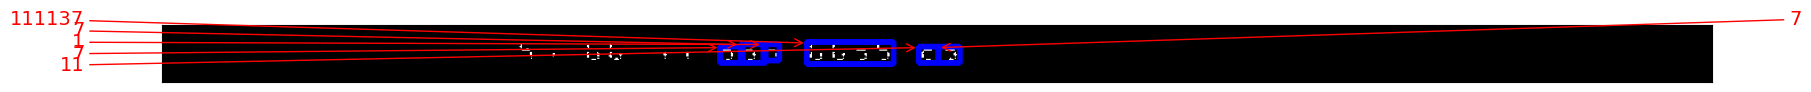

[['111137', '7', '1', '7', '11', '7']]
Filtered Image digits count: 12


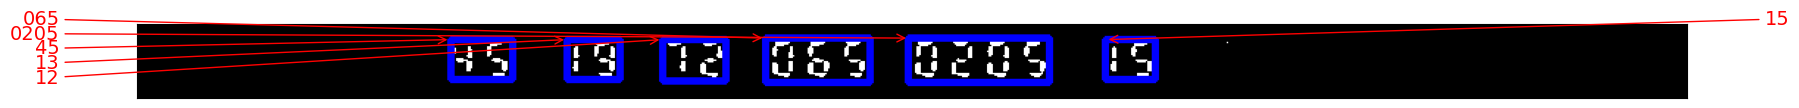

[['45', '13', '12', '065', '0205', '15']]
Filtered Image digits count: 15


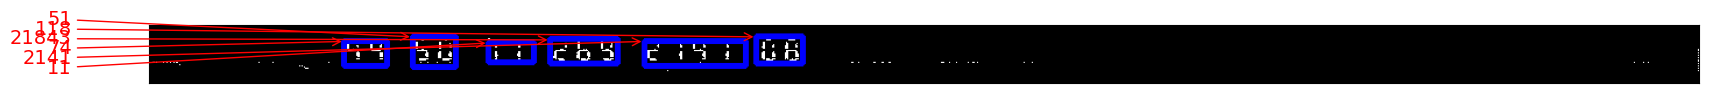

[['51', '118', '21843', '74', '2141', '11']]
Filtered Image digits count: 18


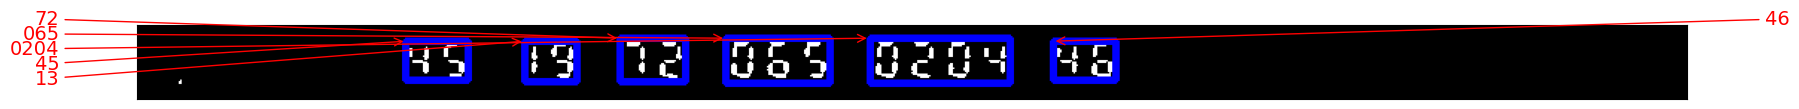

[['72', '065', '0204', '45', '13', '46']]
Filtered Image digits count: 15


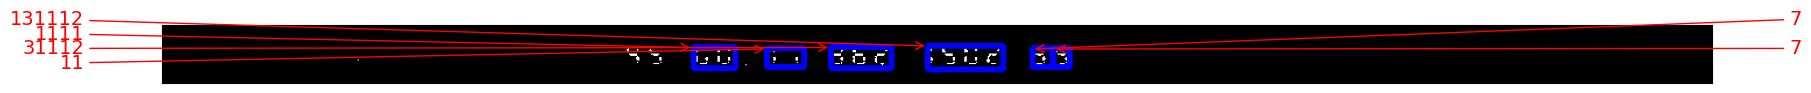

[['131112', '1111', '31112', '11', '7', '7']]
Filtered Image digits count: 19


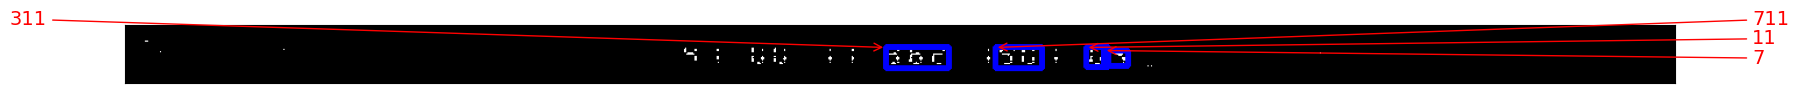

[['311', '711', '11', '7']]
Filtered Image digits count: 9


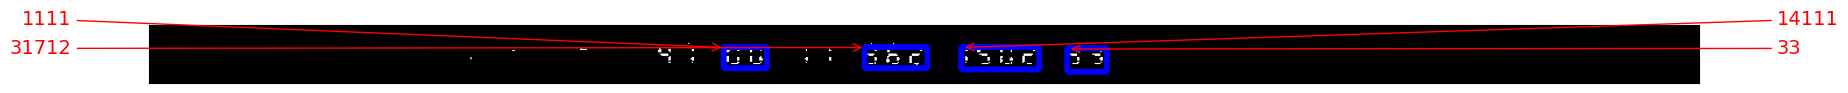

[['1111', '31712', '14111', '33']]
Filtered Image digits count: 16


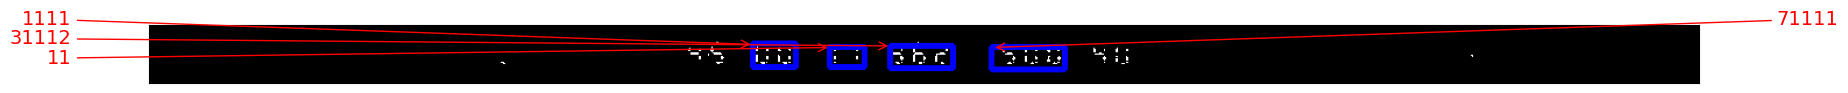

[['1111', '31112', '11', '71111']]
Filtered Image digits count: 16


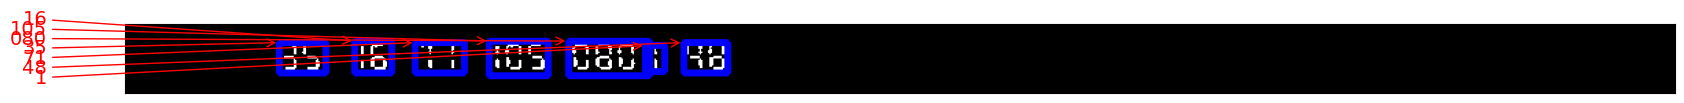

[['16', '105', '080', '35', '71', '48', '1']]
Filtered Image digits count: 15


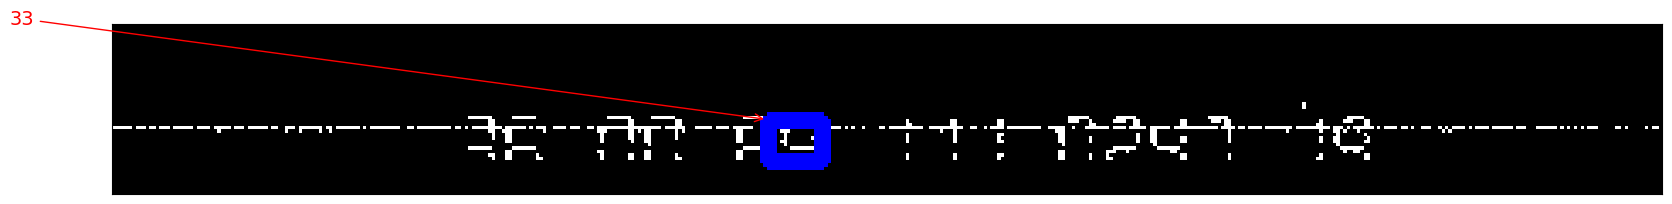

[['33']]
Filtered Image digits count: 2


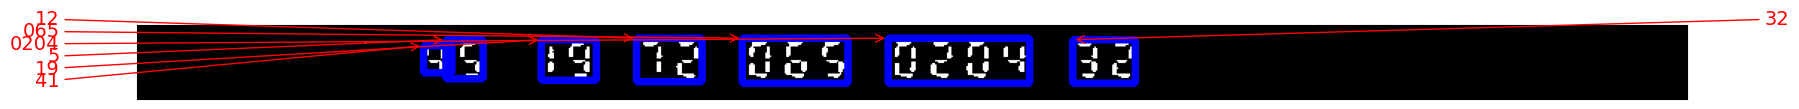

[['5', '19', '12', '065', '0204', '32', '41']]
Filtered Image digits count: 16


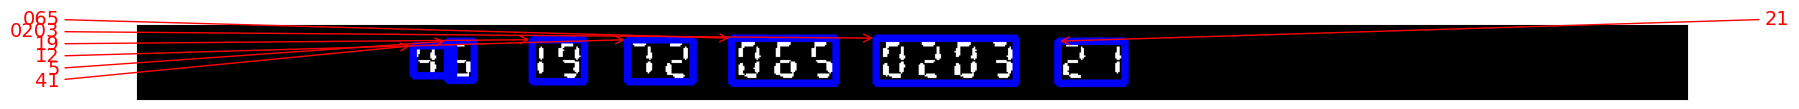

[['19', '065', '0203', '5', '12', '21', '41']]
Filtered Image digits count: 16


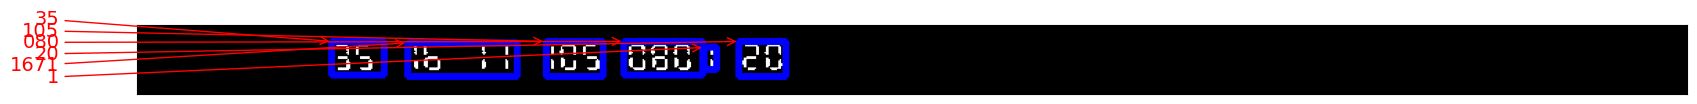

[['35', '105', '080', '20', '1671', '1']]
Filtered Image digits count: 15


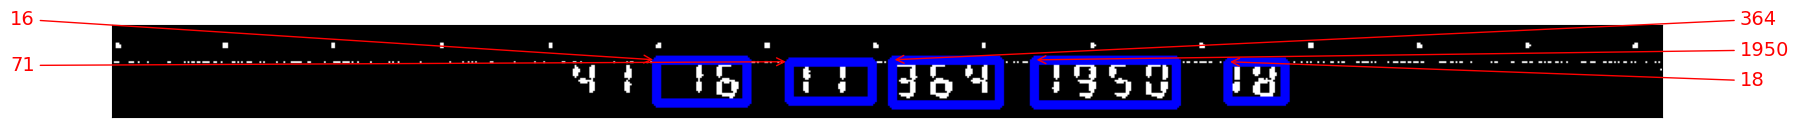

[['16', '364', '1950', '71', '18']]
Filtered Image digits count: 13


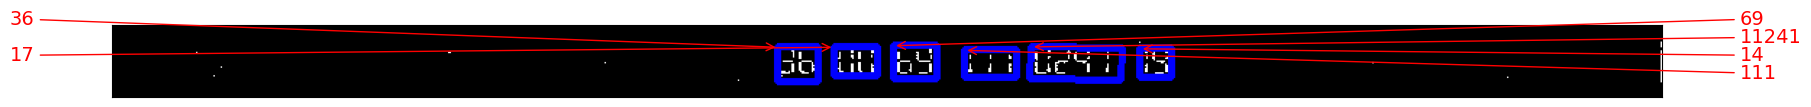

[['69', '36', '17', '11241', '14', '111']]
Filtered Image digits count: 16


In [43]:
RESULTS = []
for image in sample_set:
    digitcount_total, len_box,predicted_values = read_image(image,pipeline)
    #RESULTS.append(read_image(image,pipeline))
    RESULTS.append([image,digitcount_total, len_box,predicted_values])
    

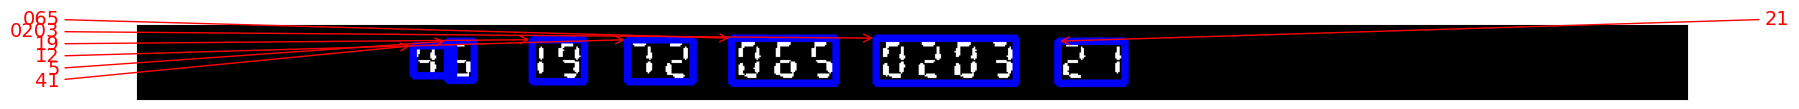

[['19', '065', '0203', '5', '12', '21', '41']]
Filtered Image digits count: 16


([16], 7, [['19', '065', '0203', '5', '12', '21', '41']])

In [35]:
read_image('C:/model/train_images/original\\11.png',pipeline)

In [50]:
filtered_accuracy = []
original_accuracy = []
for i in range(len(RESULTS)):
    filtered_accuracy.append((RESULTS[i][1][0])/15)
    #|original_accuracy.append((RESULTS[i][1][0])/15)
print("Average accuracy for filtered ionograms:", round(sum(filtered_accuracy)/sample_size,3))
#print("Average accuracy for original ionograms:", round(sum(original_accuracy)/sample_size,3))

Average accuracy for filtered ionograms: 1.003


# Test set Accuracy

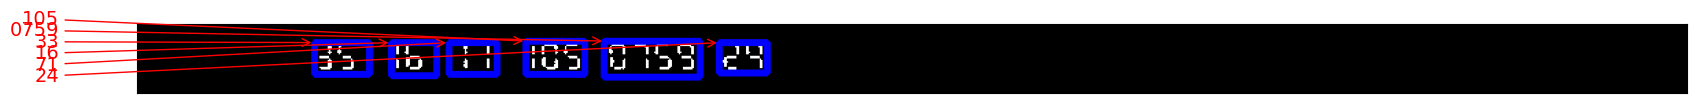

[['105', '0759', '33', '16', '71', '24']]
Filtered Image digits count: 15


In [38]:
preds = read_image('C:/model/train_images/original\\31.png',pipeline)


In [39]:
test_y = pd.read_csv('C:/model/train_images/original/labels.csv')